### **Cargue de datos**


A continuación se importan los modulos que se usaran a lo largo del desarrollo del entendimiento de los datos.

In [79]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
from pyspark.sql.functions import col, to_date
import pyspark.sql.functions as f
from pyspark.sql.types import NumericType
import os 
from datetime import datetime
from pyspark.sql import types as t
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from pyspark.sql.functions import col

Tambien se definen las credenciales de acceso a la base de datos.

In [3]:
# Given Credentials
db_user = 'Estudiante_65_202415'
db_psswd = 'Estudiante_202010409'

connection_properties = {
    "user": db_user,
    "password": db_psswd,
    "driver": "com.mysql.cj.jdbc.Driver"
}

default_string_connection = 'jdbc:mysql://157.253.236.120:8080/WWImportersTransactional'

In [4]:
# WINDOWS - Compatible with VM  
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'
#path_jar_driver = 'D:\Librerias\mysql-connector-java-8.0.28.jar'

# LINUX users: to download the jar wget https://dev.mysql.com/get/Downloads/Connector-J/mysql-connector-java-8.0.28.tar.gz
#path_jar_driver = '/opt/mysql/lib/mysql-connector-java-8.0.28.jar'

A continuaciónse crean algunas funciones que serán utiles para el desarrollo de esta exploración.

In [5]:
class MySQLConnector:
    def __init__(self, spark: SparkSession, connection_properties: dict, url: str):
        self.spark = spark
        self.properties = connection_properties
        self.url = url

    def get_dataframe(self, sql_query: str):
        """
        Execute a SQL query and return the result as a Spark DataFrame.

        Parameters:
        sql_query (str): SQL query to be executed.

        Returns:
        DataFrame: Resultant DataFrame from the executed SQL query.
        """
        df = self.spark.read.jdbc(
            url=self.url,
            table=sql_query,
            properties=self.properties
        )
        return df
    
def plot_numeric_box_plots(spark_df, sample_fraction=0.1):
    """
    Genera diagramas de caja para todas las columnas numéricas de un DataFrame de Spark.

    Parámetros:
    - spark_df: DataFrame de Spark.
    - sample_fraction: Fracción de datos a muestrear (valor entre 0 y 1). Por defecto es 1.0 (todos los datos).
    Retorna:
    - None. La función muestra los diagramas de caja.
    """
    # Identificar las columnas numéricas
    numeric_columns = [field.name for field in spark_df.schema.fields if isinstance(field.dataType, NumericType)]

    if not numeric_columns:
        print("El DataFrame no contiene columnas numéricas.")
        return

    if sample_fraction < 1.0:
        spark_df = spark_df.sample(fraction=sample_fraction)

    spark_numeric_df = spark_df.select(*numeric_columns)

    pandas_df = spark_numeric_df.toPandas()
    pandas_df = pandas_df.dropna()

    sns.set(style="whitegrid")

    num_columns = len(numeric_columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(5 * num_columns, 6))

    if num_columns == 1:
        axes = [axes]

    for ax, column in zip(axes, numeric_columns):
        sns.boxplot(y=pandas_df[column], ax=ax)
        ax.set_title(f'Diagrama de caja de {column}')
        ax.set_ylabel(column)
        ax.set_xlabel('')

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(spark_df, sample_fraction=1.0):
    """
    Genera un mapa de calor de correlaciones para todas las columnas numéricas de un DataFrame de Spark.

    Parámetros:
    - spark_df: DataFrame de Spark.
    - sample_fraction: Fracción de datos a muestrear (valor entre 0 y 1). Por defecto es 1.0 (todos los datos).

    Retorna:
    - None. La función muestra el mapa de calor de correlaciones.
    """
    numeric_columns = [field.name for field in spark_df.schema.fields if isinstance(field.dataType, NumericType)]

    if not numeric_columns:
        print("El DataFrame no contiene columnas numéricas.")
        return

    if sample_fraction < 1.0:
        spark_df = spark_df.sample(fraction=sample_fraction)

    spark_numeric_df = spark_df.select(*numeric_columns)

    pandas_df = spark_numeric_df.toPandas()

    pandas_df = pandas_df.dropna()

    corr_matrix = pandas_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Mapa de calor de correlaciones')
    plt.show()


def plot_scatter(df, x_col, y_col, sample_fraction):
    """
    Genera un gráfico de dispersión entre dos columnas de un DataFrame de Spark.

    Parámetros:
    df (DataFrame): DataFrame de Spark con los datos.
    x_col (str): Nombre de la columna para el eje x.
    y_col (str): Nombre de la columna para el eje y.
    sample_fraction (float): Porcentaje de datos a muestrear (entre 0 y 1).
    """

    if sample_fraction <= 0 or sample_fraction > 1:
        raise ValueError("El parámetro sample_fraction debe estar entre 0 y 1.")

    sample_df = df.select(x_col, y_col).sample(fraction=sample_fraction)

    pandas_df = sample_df.toPandas()

    if pandas_df.empty:
        print("No hay datos para visualizar después del muestreo. Por favor, incrementa sample_fraction.")
        return

    if pandas_df[x_col].dtype == 'object':
        try:
            pandas_df[x_col] = pd.to_datetime(pandas_df[x_col])
        except Exception as e:
            print(f"Error al convertir {x_col} a datetime: {e}")
            return

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=pandas_df, x=x_col, y=y_col)
    plt.title(f"Gráfico de dispersión de {y_col} vs {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xticks(rotation=45)  # Rotar etiquetas del eje x si es necesario
    plt.tight_layout()
    plt.show()

def create_spark_session(path_jar_driver):
    # Configuración de la sesión de Spark
    conf = SparkConf() \
            .set('spark.driver.extraClassPath', path_jar_driver)

    spark_context = SparkContext(conf=conf)
    sql_context = SQLContext(spark_context)
    spark = sql_context.sparkSession

    return spark

In [13]:
# Import reusable modules
#import modules.spark_session_module 
#import modules.mysql_connector
#import modules.mysql_connector

In [6]:
#spark = modules.spark_session_module.create_spark_session(path_jar_driver)
spark = create_spark_session(path_jar_driver)

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [7]:
conn = MySQLConnector(spark=spark, connection_properties=connection_properties, url=default_string_connection)

In [14]:
sql_beneficios = 'RaSaTransaccional.FuenteTiposBeneficio_Copia_E'
sql_planes = 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E'

In [15]:
beneficios  = conn.get_dataframe(sql_beneficios)
planes = conn.get_dataframe(sql_planes)

## **Perfilamiento de datos**

### **Entendimiento de los datos**

A continuacion se realiza el entendimiento de los datos.

In [10]:
beneficios

DataFrame[IdTipoBeneficio_T: int, Nombre: string, UnidadDelLimite: string, EsEHB: string, EstaCubiertaPorSeguro: string, TieneLimiteCuantitativo: string, ExcluidoDelDesembolsoMaximoDentroDeLaRed: string, ExcluidoDelDesembolsoMaximoFueraDeLaRed: string, Fecha: int]

In [11]:
beneficios.show()

+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|IdTipoBeneficio_T|              Nombre|     UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|
+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|              565|Nutritional Couns...|                    |   No|                  Yes|                     No|                                      No|                                    Yes| 2017|
|              795|Rehabilitative Sp...|Days per Benefit ...|  Yes|                  Yes|                    Yes|                                      No|                                    Yes| 2

Como puede observarse en el anterior dataframe, la tabla de beneficios contiene la siguiente información:
* `IdTipoBeneficio_T` que corresponde al identificador del identificador del tipo de beneficio.
* `Nombre` que corresponde a la descripción del tipo de beneficio.
* `UnidadDelLimite` Corresponde a la unidad en la que se expresa el limite del beneficio (si lo hay).
* `EsEHB` Indica si el beneficio es esencial de salud.
* `EstaCubiertaPorSeguro` Esta columna indica si el tipo de beneficio esta cubierto por el seguro.
* `TieneLimiteCuantitativo` Esta columna señala si el tipo de beneficio tiene limite cuantitativo, toma valores Yes/No.
* `ExcluidoDelDesembolsoMaximoDentroDeLaRed` Esta columna indica si el tipo de beneficio esta excluido del desembolso máximo dentro de la red, toma valores Yes/No.
* `ExcluidoDelDesembolsoMaximoFueraDeLaRed` Esta columna indica si el tipo de beneficio esta excluido del desembolso máximo fuera de la red, toma valores Yes/No.
* `Fecha` Indica el año en que se define el tipo de beneficio.

La primera columna correspondería a la llave primaria de la tabla. Solo las columnas `IdTipoBeneficio_T` y `Fecha` son de tipo entero (INT); las demas columnas son de tipo texto (STRING)

**¿Qué representa una fila de esta tabla?** Cada fila de esta tabla representa un tipo de beneficio en el sistema de salud vigilado por RaSA indicando las caracteristicas generales de cada beneficio como su descripción; unidades del limite; si es un beneficio esencial; si lo cubre el seguro; si se excluye del desembolso maximo desntro y fuera de la red; y el año de definición del beneficio.

In [13]:
beneficios.count()

849

Por último se señala que esta tabla contiene 849 registros.

### **Revisión de reglas de negocio:** 

A continuación se muestran las reglas de negocio dadas que tienen relación con la tabla tipo de beneficios:

* **(REGLA 2)**
Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen.

* **(REGLA 3)**
Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019

* **(REGLA 4)**
La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.

A continuación se hará la revisión de la `REGLA 2`.

#### REVISIÓN DE LA REGLA 2

`Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen.`


In [31]:
total = beneficios.count()
sin_duplicados = beneficios.distinct().count()
diff = total - sin_duplicados

print(f"Existen {total} registros de tipos de beneficios en la tabla de tipo de beneficios, sin embargo solo {sin_duplicados} corresponden a valores unicos. Existen {diff} valores duplicados.")

Existen 849 registros de tipos de beneficios en la tabla de tipo de beneficios, sin embargo solo 578 corresponden a valores unicos. Existen 271 valores duplicados.


Esta primera inspección indica que se debe proceder con cautela frente a los analisis cruzados con la tabla de hechos dado que puede generar muchos mas registros al intentar realizar alguna operacion de join dado que se estaria trabajando con una relación de muchos a muchos y no es optimo.

Esta tabla de tipo de beneficio deberia contener registros unicos. Sin embargo como ya se indico existen al menos 271 filas completamente duplicadas, esto se puede solucionar facilmente eliminando las filas duplicadas, sin embargo se debera consultar con el cliente acerca de este hallazgo y esperar sus comentarios para proceder.

In [28]:
beneficios_con_limite = beneficios.filter(beneficios["TieneLimiteCuantitativo"]=='Yes')
total = beneficios_con_limite.count()
sin_duplicados = beneficios_con_limite.distinct().count()
diff = total - sin_duplicados

print(f"Existen {total} tipos de beneficios indicados con limite cuantitativo en la tabla de tipo de beneficios, sin embargo solo {sin_duplicados} corresponden a valores unicos. Existen {diff} valores duplicados.")

Existen 271 tipos de beneficios indicados con limite cuantitativo en la tabla de tipo de beneficios, sin embargo solo 210 corresponden a valores unicos. Existen 61 valores duplicados.


In [29]:
registros_sin_limite = planes.filter((col("cantidadLimite") == 0) | (col("cantidadLimite").isNull()))
total = registros_sin_limite.count()
sin_duplicados = registros_sin_limite.distinct().count()
diff = total - sin_duplicados

print(f"Existen {total} tipos de planes con cantidad limite igual a cero o nula en la tabla de planes, sin embargo solo {sin_duplicados} corresponden a valores unicos. Existen {diff} valores duplicados.")

Existen 30571 tipos de beneficios con cantidad limite igual a cero o nula en la tabla de planes, sin embargo solo 23355 corresponden a valores unicos. Existen 7216 valores duplicados.


In [30]:
beneficios_con_limite_unicos = beneficios_con_limite.select("IdTipoBeneficio_T").distinct()
registros_sin_limite_unicos = registros_sin_limite.select("IdTipoBeneficio_T").distinct()

df_joined = beneficios_con_limite_unicos.join(registros_sin_limite_unicos, "IdTipoBeneficio_T", "inner")
df_joined.count()

44

Existen al menos 44 planes de beneficios para los que no se cumple la regla de negocio # 2, dado que a pesar de ser beneficios con limite cuantitativo en la tabla de planes aparecen con cantidad limite igual a cero o nula.

Luego de esta breve inspección es posible constatar que la regla de negocio # 2 no se cumple en las tablas analizadas dado que se encuentran al menos 44 beneficios marcados con 'Yes' en la columna TieneLimiteCuantitativo en la `FuenteTiposBeneficio_Copia_E` que no reflejan un limite acorde (diferente de cero) en la `FuentePlanesBeneficio_Copia_E`.

#### REVISIÓN DE LA REGLA 3

`Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019`

**Nota**
Solo se hara referencia en este analisis al cumplimiento de esta regla en la tabla `FuenteTiposBeneficio_Copia_E`

In [37]:
result = beneficios.describe("Fecha")
result.show()

+-------+-------------------+
|summary|              Fecha|
+-------+-------------------+
|  count|                849|
|   mean|  2017.208480565371|
| stddev|0.40646157760308743|
|    min|               2017|
|    max|               2018|
+-------+-------------------+



In [38]:
beneficios.groupBy("Fecha").count().orderBy("count", ascending=False).show()

+-----+-----+
|Fecha|count|
+-----+-----+
| 2017|  672|
| 2018|  177|
+-----+-----+



En la tabla solo se observan datos de los años 2017 y 2018, la regla de negocio # 3 indica que tambien incluye datos del 2019, sin embargo no hay ningún dato para dicho año. Por otra parte solo la mayoria de los datos corresponden al año 2017, lo que podria indicar falta de datos para el año 2018.

De lo anterior se puede concluir que parece haber falta de datos de los años 2018 (parcial) y de 2019 (completo). La regla # 3 no se puede validar con los datos suministrados.

#### REVISIÓN DE LA REGLA 4

`La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.`

**Nota**
Solo se hara referencia en este analisis al cumplimiento de esta regla en la tabla `FuenteTiposBeneficio_Copia_E`

In [42]:
total = beneficios.count()
sin_duplicados = beneficios.distinct().count()
diff = total - sin_duplicados

print(f"Existen {total} registros de tipos de beneficios en la tabla de tipo de beneficios, sin embargo solo {sin_duplicados} corresponden a filas unicas. Existen {diff} filas duplicadas.")

Existen 849 registros de tipos de beneficios en la tabla de tipo de beneficios, sin embargo solo 578 corresponden a filas unicas. Existen 271 filas duplicadas.


En la tabla analizada existen 578 filas unicas, valor mucho mayor que el indicado por la regla, 170. Esta es una incongruencia significativa, sin embargo se procederá a investigar la cantidad de IDs unicos en lugar de la cantidad de filas unicas.

In [44]:
beneficios_unicos_ID = beneficios.select("IdTipoBeneficio_T").distinct().count()
print(f"Existen {beneficios_unicos_ID} IDs de tipos de beneficios unicos en la tabla de tipo de beneficios.")

Existen 178 IDs de tipos de beneficios unicos en la tabla de tipo de beneficios.


Este numero mucho mas cercano al indicado por la regla # 4 lo cual indica que los IDs de tipos de beneificios no solo estan duplicados sino que tambien contiene filas que a pesar de tener el mismo ID presentan variaciones en la información de las otras columnas.

A continuación se explorará la cantidad de valores diferentes que pueden tomar las otras columnas del dataframe para los diferentes IDs.

In [52]:
for col in beneficios.columns:
    result = beneficios.groupBy("IdTipoBeneficio_T").agg(
        f.countDistinct(col).alias("num_valores_diferentes")
    )
    result_sorted = result.orderBy(f.col("num_valores_diferentes"), ascending=False)
    print(f"Revisión para la columna {col}")
    result_sorted.show()

Revisión para la columna IdTipoBeneficio_T
+-----------------+----------------------+
|IdTipoBeneficio_T|num_valores_diferentes|
+-----------------+----------------------+
|              735|                     1|
|              295|                     1|
|             1000|                     1|
|              565|                     1|
|              230|                     1|
|              205|                     1|
|              570|                     1|
|               15|                     1|
|              375|                     1|
|              180|                     1|
|              625|                     1|
|              210|                     1|
|              755|                     1|
|              820|                     1|
|              190|                     1|
|              640|                     1|
|               85|                     1|
|              140|                     1|
|             1020|                     1|
|          

De lo anterior se resalta que la columna `UnidadDelLimite` presenta el mayor numero de variaciones para cada ID de tipo de beneficio.

Por lo pronto se puede concluir que la regla # 4 referente al numero de beneficios registrados no se cumple y se debe realizar un fuerte trabajo de limpieza para organizar adecuadamente esta tabla.

### **Análisis de calidad de datos**

#### **Unicidad**

En esta sección se revisará la unicidad de los registros (filas) de la tabla y tambien de la columna de IDs ya que esta deberia contener valores unicos.

In [65]:
total = beneficios.count()
sin_duplicados = beneficios.distinct().count()
diff = total - sin_duplicados

print(f"Existen {total} registros de tipos de beneficios en la tabla de tipo de beneficios, sin embargo solo {sin_duplicados} corresponden a valores unicos. Existen {diff} valores duplicados.")

Existen 849 registros de tipos de beneficios en la tabla de tipo de beneficios, sin embargo solo 578 corresponden a valores unicos. Existen 271 valores duplicados.


In [66]:
beneficios_unicos_ID = beneficios.select("IdTipoBeneficio_T").distinct().count()
print(f"Existen {beneficios_unicos_ID} IDs de tipos de beneficios unicos en la tabla de tipo de beneficios.")

Existen 178 IDs de tipos de beneficios unicos en la tabla de tipo de beneficios.


* Hay un total de 849 filas en el dataframe
* Existen 271 filas duplicadas
* Solo hay 178 IDs unicos de beneficios

#### **Validez**

La validez de los datos es abordada de manera exhaustiva en la seccion de Analisis descriptivo. Sin embargo aqui se replican algunas de las concluiones mas relevantes frente a la validez de los datos.

In [68]:
result = beneficios.groupBy("IdTipoBeneficio_T").agg(
    f.countDistinct("Nombre").alias("num_nombres_diferentes")
)
result_sorted = result.orderBy(f.col("num_nombres_diferentes"), ascending=False)
print(f"Revisión para la columna Nombre")
result_sorted.show()

Revisión para la columna Nombre
+-----------------+----------------------+
|IdTipoBeneficio_T|num_nombres_diferentes|
+-----------------+----------------------+
|             1025|                     1|
|              540|                     1|
|              580|                     1|
|               85|                     1|
|               65|                     1|
|              970|                     1|
|              255|                     1|
|             1005|                     1|
|              375|                     1|
|              155|                     1|
|              950|                     1|
|              530|                     1|
|              115|                     1|
|              830|                     1|
|              385|                     1|
|              210|                     1|
|             1030|                     1|
|              460|                     1|
|              350|                     1|
|              860|   

* Para cada ID existe un unico Nombre o descripción del beneficio
* Las columnas `EsEHB`, `EstaCubiertaPorSeguro`, `TieneLimiteCuantitativo`, `ExcluidoDelDesembolsoMaximoDentroDeLaRed` y `ExcluidoDelDesembolsoMaximoFueraDeLaRed` toman principalmente valores 'Yes' y 'No', lo que indica que podrian modelarse como tipo booleano.
* Se necesita una mejor descripción de los atributos de la tabla y un mayor entendimiento del negocio para llegar a mejores conclusiones frente a la validez de los datos registrados.
* Para mayor detalle remitase a la sección de Analisis descriptivo donde se revisan en detalle cada columna y tambien algunas interacciones entre las categorias por medio de tablas de contingencia.

#### **Completitud**

In [74]:
# Conteo de celdas nulas
null_counts = beneficios.agg(*[f.count(when(f.col(c).isNull(), 1)).alias(c) for c in beneficios.columns])
print("Conteo de celdas nulas:")
null_counts.show()

# Conteo de celdas con espacios
columns_with_spaces_count = beneficios.agg(*[f.count(when(f.col(c).contains(" "), 1)).alias(c) for c in beneficios.columns])
print("Conteo de celdas con espacios:")
columns_with_spaces_count.show()

# Conteo de celdas vacias
columns_with_spaces_count = beneficios.agg(*[f.count(when(f.col(c) == "", 1)).alias(c) for c in beneficios.columns])
print("Conteo de celdas vacias:")
columns_with_spaces_count.show()

# Conteo de celdas con valor 0
columns_with_spaces_count = beneficios.agg(*[f.count(when(f.col(c) == 0, 1)).alias(c) for c in beneficios.columns])
print("Conteo de celdas con valor cero:")
columns_with_spaces_count.show()

Conteo de celdas nulas:
+-----------------+------+---------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|IdTipoBeneficio_T|Nombre|UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|
+-----------------+------+---------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+
|                0|     0|              0|    0|                    0|                      0|                                       0|                                      0|    0|
+-----------------+------+---------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+

Conteo de celdas con espacios:
+-----------------+------+--------

* No existen celdas nulas
* Las celdas `Nombre` y  `UnidadDelLimite` contienen espacios, esto puede ser normal dada la naturaleza del tipo de dato y la manera en que estan definidos los valores permitidos de estas columnas.
* Hay 2 valores con espacios en la columna `ExcluidoDelDesembolsoMaximoDentroDeLaRed` lo cual no es lo esperado ya que principalmente esta columna toma valores 'Yes'/'No' (ver analisis descriptivo). Sin embargo mas adelante se indicara que hay 2 registros que toman el valor 'Algunas veces'.
* La columna `UnidadDelLimite` tiene 559 datos vacios, esto parece estar dado por la naturaleza del atributo, no todos los tipos de beneficio tienen limite cuantitativo.
* No hay celdas con valor cero.

#### **Consistencia**

Dentro de las validaciones que se pueden hacer para confirmar la consistencia de los datos, se tiene que la columna `UnidadDelLimite` solo toma valores tipo texto cuando la columna `TieneLimiteCuantitativo` toma el valor de 'Si' o 'Yes' , de lo contrario es una cadena vacia "".

In [77]:
validacion = beneficios.withColumn(
    "regla_valida",
    f.when(
        (f.col("TieneLimiteCuantitativo").isin("Si", "Yes")) & (f.col("UnidadDelLimite") != ""), True
    ).otherwise(
        f.when(
            ~(f.col("TieneLimiteCuantitativo").isin("Si", "Yes")) & (f.col("UnidadDelLimite") == ""), True
        ).otherwise(False)
    )
)

invalid_rows = validacion.filter(f.col("regla_valida") == False)
invalid_rows.show()

+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+------------+
|IdTipoBeneficio_T|              Nombre|     UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|Fecha|regla_valida|
+-----------------+--------------------+--------------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-----+------------+
|              330|Habilitation Serv...|Visit(s) per Bene...|  Yes|                  Yes|                     No|                                      No|                                     No| 2018|       false|
|              820|Routine Dental Se...|Visit(s) per 6 Mo...|   No|                  Yes|                     No|                               

In [78]:
invalid_rows.count()

33

* Existen registros que tienen indicado `UnidadDelLimite` aun cuando indican que no tienen `TieneLimiteCuantitativo`.
* Existen registros que no tienen indicado `UnidadDelLimite` aun cuando indican que Si tienen `TieneLimiteCuantitativo`.
* Se tienen 33 casos como los apenas descritos.

### **Analisis Descriptivo**

In [54]:
print("Resumen general de los datos:")
beneficios.summary().show()

Resumen general de los datos:
+-------+-----------------+--------------------+-----------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-------------------+
|summary|IdTipoBeneficio_T|              Nombre|  UnidadDelLimite|EsEHB|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|              Fecha|
+-------+-----------------+--------------------+-----------------+-----+---------------------+-----------------------+----------------------------------------+---------------------------------------+-------------------+
|  count|              849|                 849|              849|  849|                  849|                    849|                                     849|                                    849|                849|
|   mean|  504.62308598351|                null|             null| null|                 n

A partir del summary anterior se puede establecer:

* La columna `IdTipoBeneficio_T` parece estar uniformemente descrita entre 5 y 1055, tomando valores enteros y sin presentar valores atipicos. De esta columna, siendo un indice, no se espera poder llegar a conclusiones relavantes pero es importante inspeccionarla para establecer si puede llegar a haber vacios de información ya que los indices numericos normalmente son consecutivos.
* Las columnas `Nombre`, `UnidadDelLimite`, `EsEHB`, `EstaCubiertaPorSeguro`, `TieneLimiteCuantitativo`, `ExcluidoDelDesembolsoMaximoDentroDeLaRed` y `ExcluidoDelDesembolsoMaximoFueraDeLaRed` son de tipo texto.
* La columna `Fecha` toma datos enteros entre 2017 y 2018.

In [57]:
for col in beneficios.columns:
    print(f"Revisión para la columna {col}")
    beneficios.groupby(col).count().orderBy("count", ascending=False).show()
    filas = beneficios.select(col).count()
    print("Conteo de filas en la columna '" + col + "': " + str(filas))
    filas_unicas = beneficios.select(col).distinct().count()
    print("Valores únicos en la columna '" + col + "': " + str(filas_unicas))
    cardinal = filas_unicas / filas
    cardinal_formateado = "{:.5f}".format(cardinal)
    print("Cardinalidad: " + str(cardinal_formateado) + "\n\n")

Revisión para la columna IdTipoBeneficio_T
+-----------------+-----+
|IdTipoBeneficio_T|count|
+-----------------+-----+
|              190|   29|
|              865|   26|
|              595|   21|
|              825|   20|
|              335|   19|
|              765|   19|
|              830|   19|
|              275|   18|
|              565|   17|
|              135|   17|
|              835|   16|
|              455|   16|
|             1000|   15|
|               10|   15|
|              640|   15|
|              820|   15|
|              795|   14|
|              330|   14|
|             1030|   14|
|              735|   13|
+-----------------+-----+
only showing top 20 rows

Conteo de filas en la columna 'IdTipoBeneficio_T': 849
Valores únicos en la columna 'IdTipoBeneficio_T': 178
Cardinalidad: 0.20966


Revisión para la columna Nombre
+--------------------+-----+
|              Nombre|count|
+--------------------+-----+
|Dental Check-Up f...|   29|
|Skilled Nursing F...|   2

Algunas observaciones a partir del resultado mostrado:

* Las columnas `IdTipoBeneficio_T` y `Nombre` tienen 178 datos unicos y una cardinalidad de 0.20966 la mas alta del dataframe.
* La columna `UnidadDelLimite` tiene 63 valores unicos y una cardinalidad de 0.07420. Se debe tener en cuenta que po definicion esta columna puede estar vacia y de hecho lo está en la mayoria de los registros (559) representando un 65.8% del total (incluyendo los duplicados).
* La columna `EsEHB` cuenta con 3 valores unicos, siendo uno de ellos el valor 'True' que posiblemente puede imputarse como un 'Yes'. Sin embargo esto debe consultarse con el cliente para definir reglas de imputación. La cardinalidad es de 0.00353.
* La columna `EstaCubiertaPorSeguro` cuenta con 3 valores unicos, siendo uno de ellos el valor 'False' que posiblemente puede imputarse como un 'No'. Sin embargo esto debe consultarse con el cliente para definir reglas de imputación. La cardinalidad es de 0.00353.
* La columna `TieneLimiteCuantitativo` cuenta con 4 valores unicos, siendo uno de ellos el valor 'Nein' que posiblemente puede imputarse como un 'No' y el valor 'Si' que posiblemente puede imputarse como un 'Yes'. Sin embargo esto debe consultarse con el cliente para definir reglas de imputación. La cardinalidad es de 0.00471.
* La columna `ExcluidoDelDesembolsoMaximoDentroDeLaRed` cuenta con 3 valores unicos, siendo uno de ellos el valor 'Algunas veces' apareciendo un total de 2 veces. Esto debe consultarse con el cliente para definir se dicho valor debe considerarse como valido para esta columna o si debe imputarse a 'Yes' o 'No'. La cardinalidad es de 0.00353.
* La columna `ExcluidoDelDesembolsoMaximoFueraDeLaRed` cuenta con 2 valores unicos 'Yes' y 'No'. La cardinalidad es de 0.00236.
* La columna `Fecha` cuenta con 2 valores unicos '2017' y '2018'. La cardinalidad es de 0.00236.

array([[<AxesSubplot:title={'center':'IdTipoBeneficio_T'}>]], dtype=object)

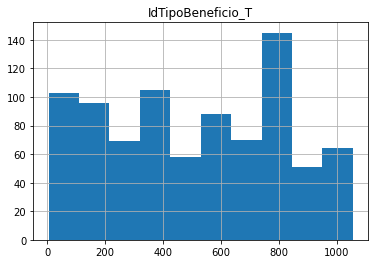

In [58]:
beneficios.select('IdTipoBeneficio_T').toPandas().hist()

array([[<AxesSubplot:title={'center':'Fecha'}>]], dtype=object)

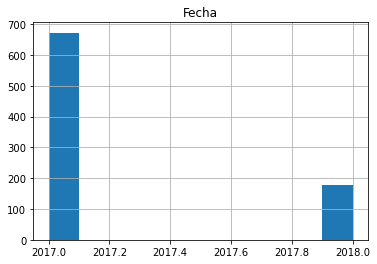

In [59]:
beneficios.select('Fecha').toPandas().hist()

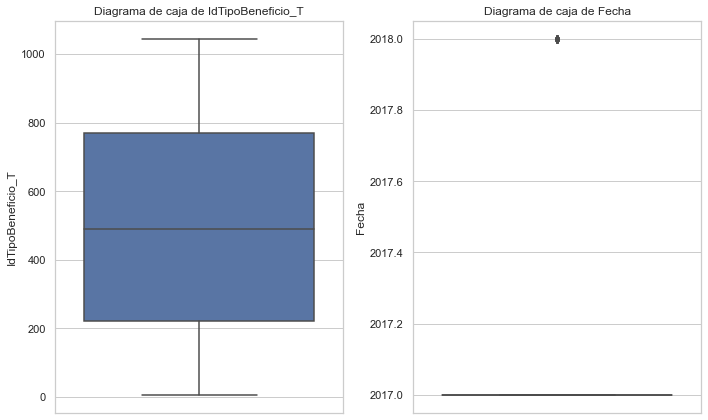

In [80]:
plot_numeric_box_plots(beneficios)

In [62]:
contingency_table = beneficios.distinct().groupBy("EsEHB", "EstaCubiertaPorSeguro").agg(count("*").alias("count")).orderBy("count", ascending=False)
contingency_table.show()

+-----+---------------------+-----+
|EsEHB|EstaCubiertaPorSeguro|count|
+-----+---------------------+-----+
|  Yes|                  Yes|  282|
|   No|                  Yes|  216|
|   No|                   No|   39|
|  Yes|                   No|   18|
| True|                  Yes|   16|
|   No|                False|    5|
| True|                   No|    1|
|  Yes|                False|    1|
+-----+---------------------+-----+



* La mayoria de los beneficios esenciales de salud estan cubiertos por los seguros.
* Hay al menos 20 beneficios esenciales de salud no cubiertos por los seguros.

In [63]:
contingency_table = beneficios.distinct().groupBy("ExcluidoDelDesembolsoMaximoDentroDeLaRed", "ExcluidoDelDesembolsoMaximoFueraDeLaRed").agg(count("*").alias("count")).orderBy("count", ascending=False)
contingency_table.show()

+----------------------------------------+---------------------------------------+-----+
|ExcluidoDelDesembolsoMaximoDentroDeLaRed|ExcluidoDelDesembolsoMaximoFueraDeLaRed|count|
+----------------------------------------+---------------------------------------+-----+
|                                      No|                                     No|  344|
|                                      No|                                    Yes|  197|
|                                     Yes|                                    Yes|   33|
|                           Algunas veces|                                    Yes|    2|
|                                     Yes|                                     No|    2|
+----------------------------------------+---------------------------------------+-----+



* La mayoria de los beneficios que NO están `ExcluidoDelDesembolsoMaximoDentroDeLaRed` tampoco están `ExcluidoDelDesembolsoMaximoFueraDeLaRed`.
* Se necesita comprender en mayor profundidad el significado de las columnas `ExcluidoDelDesembolsoMaximoDentroDeLaRed` y `ExcluidoDelDesembolsoMaximoFueraDeLaRed`.

In [64]:
contingency_table = beneficios.distinct().groupBy("EstaCubiertaPorSeguro", "TieneLimiteCuantitativo").agg(count("*").alias("count")).orderBy("count", ascending=False)
contingency_table.show()

+---------------------+-----------------------+-----+
|EstaCubiertaPorSeguro|TieneLimiteCuantitativo|count|
+---------------------+-----------------------+-----+
|                  Yes|                     No|  283|
|                  Yes|                    Yes|  209|
|                   No|                     No|   51|
|                  Yes|                   Nein|   12|
|                  Yes|                     Si|   10|
|                   No|                   Nein|    6|
|                False|                     No|    6|
|                   No|                    Yes|    1|
+---------------------+-----------------------+-----+



* La mayoria de los beneficios cubiertos por los seguros no tienen limite cuantitativo (295).
* Existen al menos 219 tipos de beneficios cubiertos por los seguros que tienen limite cuantitativo.
* Hay solo 1 tipo de beneficio con limite cuantitativo no cubierto por el seguro.

### Conclusiones

Las conclusiones serán consolidadas en un solo documento aparte, sin embargo a lo largo de este Notebook se han dejado suficientes comentarios y conclusiones de cada sección.
